In [6]:
import time
import random
import tempfile
from trie_memfs import TrieMemoryFileSystem
import fsspec
import pandas as pd
pd.set_option("display.float_format", "{:.3e}".format)
from morefs.dict import DictFS
from morefs.memory import MemFS

tempdir = tempfile.TemporaryDirectory()

def random_bytes(size: int, seed: int):
    """Generate deterministic random bytes."""
    rnd = random.Random(seed)
    return rnd.randbytes(size) if hasattr(rnd, "randbytes") else bytes(
        rnd.getrandbits(8) for _ in range(size)
    )

def make_tree(fs: fsspec.AbstractFileSystem, base_path: str, depth: int, n_dirs: int, n_subdirs: int, n_files: int, random_file: bytes, file_list: list[str]):
    """Create a synthetic directory tree with files in given filesystem."""
    def _populate(path, level):
        if level >= depth:
            return
        for d in range(n_dirs if level == 0 else n_subdirs):
            dir_path = f"{path}/dir_{level}_{d}"
            fs.mkdirs(dir_path, exist_ok=True)
            for f in range(n_files):
                file_path = f"{dir_path}/file_{f}.bin"
                with fs.open(file_path, "wb") as fobj:
                    fobj.write(random_file)
                    file_list.append(file_path)
            _populate(dir_path, level + 1)
    _populate(base_path, 0)
    return file_list

def time_call(func, *args, repeat=3, **kwargs):
    """Time a callable, returning average duration."""
    times = []
    for _ in range(repeat):
        start = time.perf_counter()
        func(*args, **kwargs)
        times.append(time.perf_counter() - start)
    return sum(times) / len(times)

def run_benchmarks(file_systems: dict[str, fsspec.AbstractFileSystem], seed: int, file_size: int, depth: int, n_dirs: int, n_sub_dirs: int, n_files: int):
    content = random_bytes(file_size, seed)

    results = []
    for fs_name, fs in file_systems.items():
        if fs_name == "local":
            base = tempdir.name
        else:
            base = f"/benchmark_{fs_name}"
        print(f"\nCreating tree in {fs_name}...")
    # make_tree(fs, base, DEPTH, N_DIRS, N_SUBDIRS, N_FILES, content)
        file_list = []
        # Benchmark operations
        timings = {
            "make_tree": time_call(lambda: make_tree(fs, base, depth, n_dirs, n_sub_dirs, n_files, content, file_list), repeat=1),
            "ls_root": time_call(fs.ls, base, detail=True),
            "walk": time_call(lambda: list(fs.walk(base))),
        }

        def cat_random_files():
            for file in file_list:
                fs.cat(file)
        timings["cat_random_file"] = time_call(cat_random_files)

        timings["rm"] = time_call(lambda: fs.rm(base, recursive=True), repeat=1)
        results.append({
            "filesystem": fs_name,
            **timings
        })

    df = pd.DataFrame(results)
    return df

In [7]:

results = run_benchmarks(
    file_systems={
        "trie_memory": TrieMemoryFileSystem(),
        "memory": fsspec.filesystem("memory"),
        "local": fsspec.filesystem("file"),
        "morefs_DictFS": DictFS(),
        "morefs_MemFS": MemFS()
    },
    seed=42,
    n_dirs=10,
    n_sub_dirs=2,
    n_files=20,
    depth=2,
    file_size=1024,
)
display(results)


Creating tree in trie_memory...

Creating tree in memory...

Creating tree in local...

Creating tree in morefs_DictFS...

Creating tree in morefs_MemFS...


,filesystem,make_tree,ls_root,walk,cat_random_file,rm
0,trie_memory,5.416e-02,2.365e-04,3.331e-04,1.912e-02,9.404e-03
1,memory,2.048e-02,9.581e-04,1.619e-02,1.499e-02,1.965e-02
2,local,1.129e+00,2.022e-04,6.484e-03,5.900e-01,1.992e-01
3,morefs_DictFS,1.419e-02,1.273e-05,1.094e-03,1.179e-02,6.596e-04
4,morefs_MemFS,2.384e-02,1.079e-04,2.243e-03,1.309e-02,1.253e-02


<Axes: xlabel='filesystem', ylabel='time [s]'>

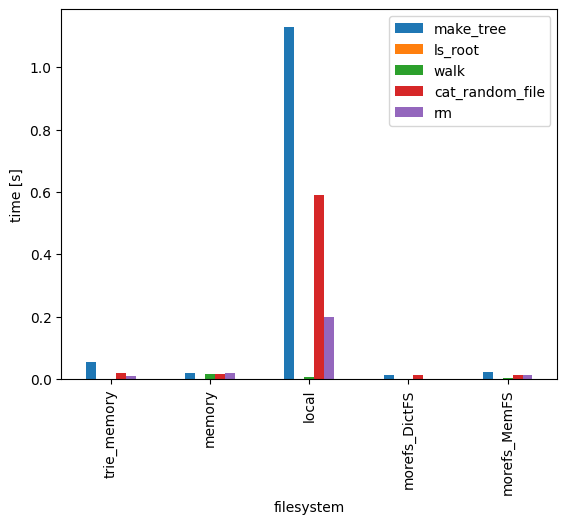

In [10]:
results.set_index("filesystem").plot(kind="bar", ylabel="time [s]")

In [11]:
results_bigger = run_benchmarks(
    file_systems={
        "trie_memory": TrieMemoryFileSystem(),
        #"memory": fsspec.filesystem("memory"),  # too slow to include
        #"local": fsspec.filesystem("file"), # too slow to include
        "morefs_DictFS": DictFS(),
        "morefs_MemFS": MemFS()
    },
    seed=42,
    n_dirs=20,
    n_sub_dirs=8,
    n_files=20,
    depth=4,
    file_size=1024,
)
display(results_bigger)


Creating tree in trie_memory...

Creating tree in morefs_DictFS...

Creating tree in morefs_MemFS...


,filesystem,make_tree,ls_root,walk,cat_random_file,rm
0,trie_memory,5.692e+00,1.713e-04,8.659e-02,2.675e+00,2.152e+00
1,morefs_DictFS,6.706e+00,2.207e-05,1.021e+00,4.676e+00,2.285e-01
2,morefs_MemFS,8.750e+00,1.103e-04,1.003e+00,5.056e+00,2.852e+00


<Axes: xlabel='filesystem', ylabel='time [s]'>

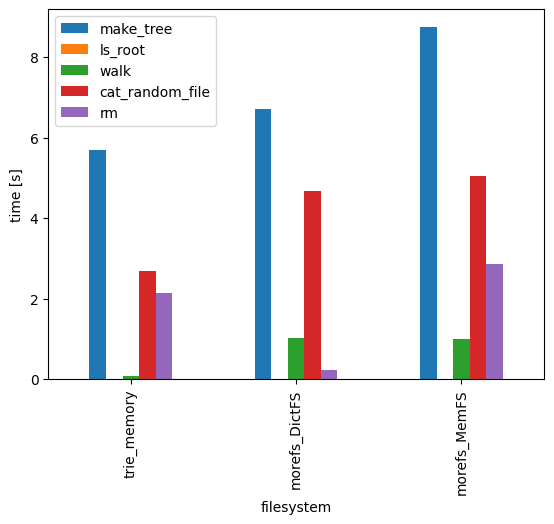

In [12]:
results_bigger.set_index("filesystem").plot(kind="bar", ylabel="time [s]")